In [1]:
#%matplotlib notebook
import matplotlib.pyplot as plt
import numpy
import sys
from scipy import ndimage

import h5py
import time

from sscPimega import pi135D
from sscPimega import pi540D
from sscPimega import misc

from PIL import Image
import cupy

import matplotlib.colors as mcolors 

from skimage.morphology import binary_dilation

In [2]:
from scipy import interpolate

def zoom_feature(img,a):
    xx = numpy.linspace(-1.0,1.0,img.shape[1])
    yy = numpy.linspace(-1.0,1.0,img.shape[0])
    fun =  interpolate.RectBivariateSpline(xx, yy, img, kx=1, ky=1, s=0)
    x = numpy.linspace(-a,a,img.shape[0])
    return fun(x,x)

In [3]:
def projection_M_gpu_old( x, data ):
    
    fft    = cupy.fft.fftn( x ) 
    phi    = cupy.angle( fft )
    result = data * cupy.exp(1j * phi)
        
    result[data<0] =  fft[data<0]
    
    result = cupy.fft.ifftn( result )
    
    return result
    

def projection_M_gpu( x, data ):
    fft    = cupy.fft.fftn( x ) 
    phi    = cupy.angle( fft )
    result = data * cupy.exp(1j * phi)
    diff =  numpy.abs(fft) - data 
    adiff = numpy.abs(diff)
    
    result[(data<0) | (adiff < 1)] =  fft[(data<0) | (adiff<1) ]
    
    tol = 1e-5 #jump@
    
    result[(data>=0) & (adiff >=1)] = fft[(data>=0) & (adiff>=1) ] * ( data[(data>=0) & (adiff>=1)] / ( numpy.maximum( numpy.abs(fft)[(data>=0) & (adiff>=1)] - diff[(data>=0) & (adiff>=1)]/ adiff[(data>=0) & (adiff>=1)], tol) ) )
    
    result = cupy.fft.ifftn( result )
    
    return result
    
    
def projection_S ( x, supp ):
    return x * supp

def projection_N ( x, supp ):
    #y = numpy.copy(x)
    #y.imag = 0
    #return y
    
    y    = numpy.copy(x.real)
    mask = (y < 0)
    y[ mask ] = 0
    return y


def hio_gpu_old( initial, measure, support, niteration, beta, method):
        
    dsupport = cupy.array(support)    
    smeasure = cupy.array( measure )
    x        = cupy.array( initial )
    csupport = cupy.array( 1-support )
    
    if method == "ER":
        idx = 0
        while ( idx < niteration ):
            y = projection_M_gpu_old( x, smeasure )
            x = projection_S( y, dsupport )
            #x = projection_N( x, dsupport)
            idx += 1
        
    if method == "HIO":
        idx = 0
        while ( idx < niteration ):
            #eu
            y = projection_M_gpu_old( x, smeasure )
            x = projection_S( y, dsupport ) + projection_S( x - beta * y,  csupport )        
            idx += 1
        
    return x.get()


def hio_gpu( initial, measure, support, niteration, beta, method):
        
    dsupport = cupy.array(support)    
    smeasure = cupy.array( measure )
    x        = cupy.array( initial )
    csupport = cupy.array( 1-support )
    
    if method == "ER":
        idx = 0
        while ( idx < niteration ):
            y = projection_M_gpu( x, smeasure )
            x = projection_S( y, dsupport )
            #x = projection_N( x, dsupport)
            idx += 1
        
    if method == "HIO":
        idx = 0
        while ( idx < niteration ):
            #Russell/Baushke
            #y = projection_M_gpu( x, smeasure )
            #x = projection_S( y, dsupport ) + projection_S( x - beta * y,  csupport )
            
            #GCC
            y = projection_M_gpu( x, smeasure )
            vsupport = (y.real >= 0) * dsupport
            x = projection_S( y, vsupport ) + projection_S( x - beta * y,  1-vsupport )
        
            idx += 1
        
    return x.get()
    
def oss_gpu( measure, support, niteration, beta ):

    dsupport = cupy.array(support)    
    smeasure = cupy.array( measure )
    x        = cupy.array( support )
    csupport = cupy.array( 1-support )
    
    ###
    
    n     = support.shape[0]
    t     = numpy.linspace(-1,1,n)
    xx,yy = numpy.meshgrid(t,t)
    xx_d  = cupy.array(xx)
    yy_d  = cupy.array(yy)
        
    G = lambda sigma: ( (1/(sigma*numpy.sqrt(2*numpy.pi))) * numpy.exp( -( (xx_d**2 + yy_d**2) / (2*sigma**2) ) ) )
    
    #smeasure = measure
    #x        = numpy.fft.ifft2( measure * numpy.exp(1j * numpy.random.rand(n) )).real

    idx = 0
    sigma = n

    while ( idx < niteration ):

        y = projection_M_gpu( x, smeasure )

        #z = conv (G, x - beta * y)
        Gaussian = G(sigma)
        Gaussian = Gaussian/Gaussian.max().max()
        
        z = numpy.fft.ifft2( numpy.fft.fftshift(Gaussian) * numpy.fft.fft2(x-beta*y) )
        
        x = projection_S( y, dsupport ) + projection_S( z,  csupport )

        x = projection_N( x, dsupport )
        
        idx += 1

        if idx % 5 == 0:
            sigma = sigma / 2.0
        
        #print (idx)   

    return x.get()
    
def get_roi( data , yc, xc, roi):
    #return data[ max(0,yc - roi): min(yc + roi,data.shape[0]) , max(0,xc - roi): min(xc + roi,data.shape[1])]
    return data[yc - roi: yc + roi, xc - roi: xc + roi  ]
    
def set_border( data, p):
    r,c = data.shape
    new = numpy.copy(data)
    new[0:p,:] = -1
    new[r-p:r,:] = -1
    new[:,0:p] = -1
    new[:,c-p:r] = -1
    return new
    
def get_diffractogram3d( diff2d, roi , eps ):
    
    nangles = diff2d.shape[0]
    imgsize = diff2d.shape[1]
    
    angles     = numpy.linspace(-numpy.pi/2.,numpy.pi/2., nangles,endpoint=False)
    
    x0    = -1
    xf    =  1
    t     = numpy.linspace(x0,xf,2*roi,endpoint=False)
    dxyz  = t[1] - t[0]
    xx,yy = numpy.meshgrid(t,t)
    c     = t[roi]

    output = numpy.zeros([2*roi,2*roi,2*roi],dtype=numpy.float32)
    count   = numpy.zeros([2*roi,2*roi,2*roi],dtype=numpy.float32)
    #eps    = [1,1]

    s = eps
    beamstop = (xx**2 + yy**2 < (s*dxyz)**2 ) 
    
    for k in range(nangles):

        image = get_roi( diff2d[k,:,:], imgsize//2, imgsize//2, roi) 
        image[ beamstop ] = -1 
                
        #print(k,' from ',1024)
        #rotation
        RY = numpy.array([[numpy.cos(angles[k]), 0, numpy.sin(angles[k])],[0,1,0],[-numpy.sin(angles[k]),0,numpy.cos(angles[k])]])

        xr = RY[0,0] * (xx-c) + RY[0,1] * (yy-c) + RY[0,2] * (-0)
        yr = RY[1,0] * (xx-c) + RY[1,1] * (yy-c) + RY[1,2] * (-0)
        zr = RY[2,0] * (xx-c) + RY[2,1] * (yy-c) + RY[2,2] * (-0)

        ix = ( numpy.floor( (xr - x0)/dxyz )).astype(numpy.int) 
        iy = ( numpy.floor( (yr - x0)/dxyz )).astype(numpy.int)
        iz = ( numpy.floor( (zr - x0)/dxyz )).astype(numpy.int)

        ix[ ix < 0] = 0
        ix[ ix > 2*roi - 1] = 2*roi - 1
        iy[ iy < 0] = 0
        iy[ iy > 2*roi - 1] = 2*roi - 1
        iz[ iz < 0] = 0
        iz[ iz > 2*roi - 1] = 2*roi - 1    

        count[ix,iy,iz] += 1
        output[ix, iy, iz] =  image

    mask = (output == -1)
    output[ count > 0] = output[count > 0] / count[ count > 0 ]
    output[mask] = -1
        
    return output



def get_diffractogram3d_new( diff2d, roi , distance, eps ):
    
    pxl     = 55 * 1e-6 #m
    detsize = pxl * 3072
    
    nangles = diff2d.shape[0]
    imgsize = diff2d.shape[1]
    
    angles     = numpy.linspace(-numpy.pi/2.,numpy.pi/2.,nangles, endpoint=False)
    
    x0    = -detsize/2.
    xf    =  detsize/2.
    t     = numpy.linspace(x0, xf, 2*roi, endpoint=True) 
    dxyz  = t[1] - t[0]
    xx,yy = numpy.meshgrid(t,t)
        
    energy      = 8 * 1000             # ev
    cvel        = 299792458            # m/s
    planck      = 4.135667662e-15      # ev * s
    wavelength  = cvel * planck/ (energy)        
    iwavel      = 1 #1/wavelength
    
    inv = numpy.sqrt(xx**2 + yy**2 + distance**2 ) 
    qx  = iwavel * xx / inv
    qy  = iwavel * yy / inv
    qz  = iwavel * (distance / inv - 1 )
    
    qx0 = t[0] #qx.min()
    qy0 = t[0] #qy.min()
    qz0 = t[0] #qz.min()
    cx = 0 # (qx.max() + qx.min())/2.
    cy = 0 # (qy.max() + qy.min())/2.
    
    output = numpy.zeros([2*roi,2*roi,2*roi],dtype=numpy.float32)
    count   = numpy.zeros([2*roi,2*roi,2*roi],dtype=numpy.float32)

    s = eps
    beamstop = ((xx-t[roi])**2 + (yy-t[roi])**2 < (s*dxyz)**2 ) 
    
    for k in range(nangles):

        image = get_roi( diff2d[k,:,:], imgsize//2, imgsize//2, roi) 
        image[ beamstop ] = -1 
                
        #plt.figure(figsize=(10,10))
        #libcat.Show([image])
            
        #rotation
        RY = numpy.array([[numpy.cos(angles[k]), 0, numpy.sin(angles[k])],[0,1,0],[-numpy.sin(angles[k]),0,numpy.cos(angles[k])]])
        xr = RY[0,0] * (qx-cx) + RY[0,1] * (qy-cy) + RY[0,2] * (qz)
        yr = RY[1,0] * (qx-cx) + RY[1,1] * (qy-cy) + RY[1,2] * (qz)
        zr = RY[2,0] * (qx-cx) + RY[2,1] * (qy-cy) + RY[2,2] * (qz)

        ix = ( numpy.floor( (xr - qx0)/dxyz )).astype(numpy.int) 
        iy = ( numpy.floor( (yr - qy0)/dxyz )).astype(numpy.int)
        iz = ( numpy.floor( (zr - qz0)/dxyz )).astype(numpy.int)

        ix[ ix < 0] = 0
        ix[ ix > 2*roi - 1] = 2*roi - 1
        iy[ iy < 0] = 0
        iy[ iy > 2*roi - 1] = 2*roi - 1
        iz[ iz < 0] = 0
        iz[ iz > 2*roi - 1] = 2*roi - 1    

        count[ix,iy,iz] += 1
        output[ix, iy, iz] =  image

    mask = (output == -1)
    output[ count > 0] = output[count > 0] / count[ count > 0 ]
    output[mask] = -1
        
    return output

# Simulation/Beamline

In [5]:
from sscPhantom import donuts, mario
from sscRadon import radon
from sscBst import backprojection
import time
import matplotlib.pyplot as plt
import numpy

In [6]:
energy  = 8 #kev
n       = 256
nproc   = 140
nangles = 1024

mario: (256, 256, 256) 33.6MB
Elapsed  0.8953132629394531  seconds


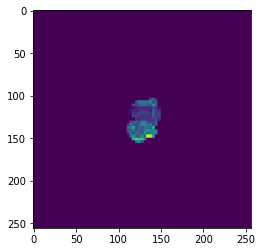

In [7]:
#s = time.time()
#phantom, supp3d_donuts = donuts.createDonuts(n, nproc, energy)
#e = time.time() - s
#print('Elapsed ', e, ' seconds')
#phantom += supp3d_donuts

s = time.time()
phantom = mario.createMario(shape=n, noise=False, zoom=0.3)
e = time.time() - s
print('Elapsed ', e, ' seconds')

plt.imshow(phantom.mean(1))

In [27]:
def build_artifacts(n, ngaps, sgap, sbstop, radius):

    gaps = numpy.zeros([n,n])

    #ngaps = 4
    #sgap = 5
    
    b = n//ngaps

    for k in range( ngaps-1 ): 
        start = (k+1)*b
        end   = start + sgap
        gaps[:, start:end ] = 1
        gaps[start:end, :] = 1

    def build_beamstop(n, center, theta, size):
        t = numpy.linspace(-1,1,n)
        dt = t[1] - t[0]
        x, y = numpy.meshgrid(t,t) 
        xc, yc = center
        th = theta
        cos = numpy.cos(th * numpy.pi/180.)
        sin = numpy.sin(th * numpy.pi/180.)
        cos2 = numpy.cos(th * numpy.pi/180. + numpy.pi/2.)
        sin2 = numpy.sin(th * numpy.pi/180. + numpy.pi/2.)
        m1 = (x-t[xc])*cos + (y-t[yc])*sin <  size[1]*dt
        m2 = (x-t[xc])*cos + (y-t[yc])*sin > -size[2]*dt
        m3 = (x-t[xc])*cos2 + (y-t[yc])*sin2 > size[0]*dt
        z =  ( m1 & m2 & m3 ).astype(numpy.double)

        return z

    beamstop = build_beamstop(n, [n//2, n//2], -34, [-5,sbstop,sbstop])

    noise = numpy.zeros([n,n])
    ix = numpy.random.randint(n, size=(n//4,n//4))
    iy = numpy.random.randint(n, size=(n//4,n//4))
    noise[iy,ix] = 1

    ## gradient to produce a strong artifact 
    
    t = numpy.linspace(-1,1,n)
    dt = t[1] - t[0]
    x, y = numpy.meshgrid(t,t) 
    y = numpy.flipud(y)
    
    th = 80
    cos = numpy.cos(th * numpy.pi/180.)
    sin = numpy.sin(th * numpy.pi/180.)
    
    #nn = [cos, sin]
    #grad =  x * nn[0] + y * nn[1] + 1
    #grad *= 1.0/grad.max()
    
    grad = numpy.exp(-( (x-t[n//2])**2 + (y-t[n//2])**2 )/400)

    mask = ( x**2 + y**2 < (radius*dt)**2 )
    
    return noise, gaps, beamstop, grad, mask

noise, gaps, beamstop, grad, circ = build_artifacts(n, 4, 5, 10, 10)

#plt.figure(figsize=(20,20))
#plt.imshow(grad)
#plt.colorbar()

In [9]:
fphantom = numpy.abs( numpy.fft.fftshift( numpy.fft.fftn(phantom) ) )**2

In [10]:
tomogram = numpy.zeros([n,n,nangles])
for k in range(n):
    tomogram[k,:,:] = radon.radon_gpu( phantom[k,:,:], nangles, device=0).T

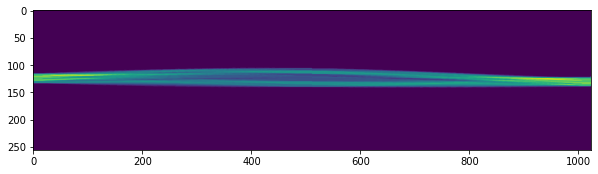

In [11]:
plt.figure(figsize=(10,10))
plt.imshow(tomogram[150,:,:])

In [ ]:
diffractogram2d = numpy.zeros([nangles, n, n])

for k in range(nangles):
    diffractogram2d[k, :, :] = numpy.abs( numpy.fft.fftshift( numpy.fft.fft2(tomogram[:,:,k]) ) )**2

array([-1.00000000e+01, -1.00000000e-01,  0.00000000e+00,  3.15837205e+01,
        9.97531398e+02,  3.15057528e+04,  9.95068890e+05,  3.14279777e+07,
        9.92612461e+08,  3.13503945e+10,  9.90162096e+11,  3.12730029e+13])

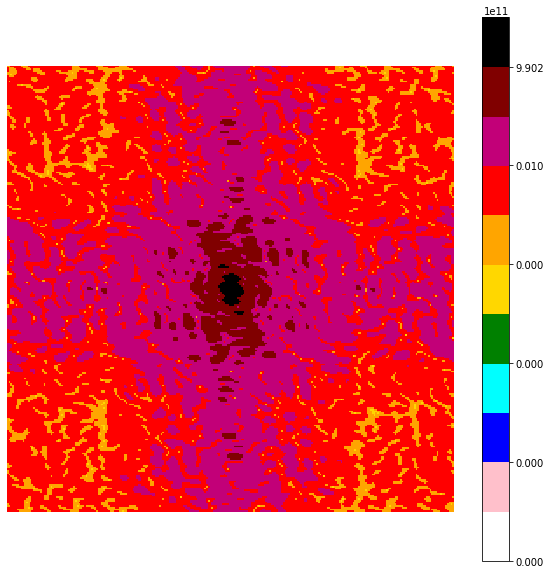

In [13]:
misc.imshow(diffractogram2d[0,:,:], (10,10))

#plt.figure(figsize=(10,10))
#libcat.Show([ diffractogram2d[0,:,:]] )

(256, 256)


array([-1.00000000e+01, -1.00000000e-01,  0.00000000e+00,  2.90284567e+01,
        8.42651299e+02,  2.44608668e+04,  7.10061212e+05,  2.06119812e+07,
        5.98334003e+08,  1.73687127e+10,  5.04186925e+11,  1.46357683e+13])

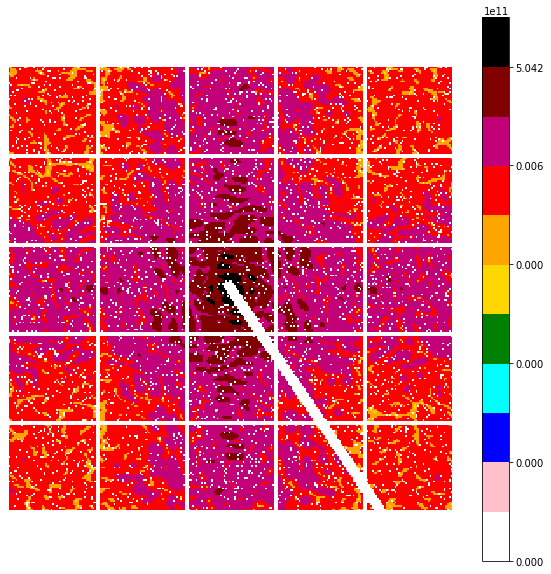

In [236]:
k = 0

noise, gaps, beamstop, grad, circ = build_artifacts(n, 5, 2, 3,4)

#beamstop = numpy.roll(beamstop, 0, axis=1)
#beamstop = numpy.roll(beamstop, 2, axis=0)

data = numpy.copy( diffractogram2d[k,:,:] ) * grad

data[ gaps > 0] = -1
data[ noise > 0] = -1
data[ beamstop > 0] = -1
#data[ circ > 0] = -1
#data[ data.shape[0]//2:data.shape[0], data.shape[1]//2:data.shape[1] ] = -1

boundary = 1
data     = set_border(data, boundary)

print(data.shape)

misc.imshow(data, (10,10))

array([-1.00000000e+01, -1.00000000e-01,  0.00000000e+00,  3.15837205e+01,
        9.97531398e+02,  3.15057528e+04,  9.95068890e+05,  3.14279777e+07,
        9.92612461e+08,  3.13503945e+10,  9.90162096e+11,  3.12730029e+13])

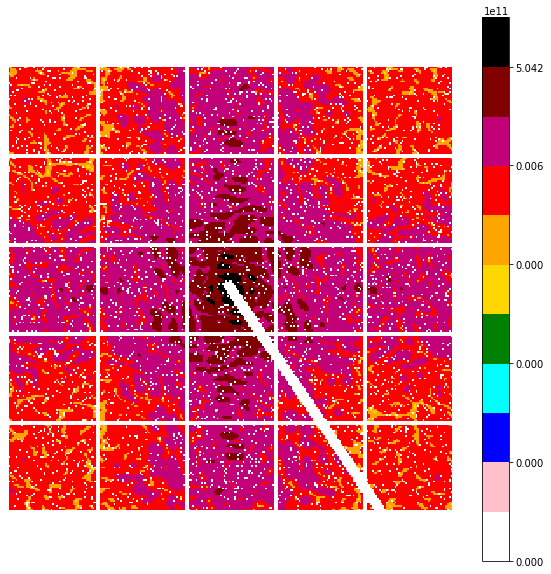

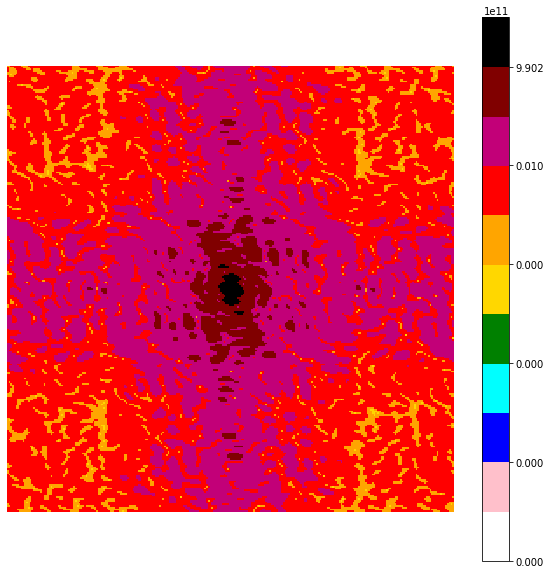

In [237]:
def symmetry( roi ):

    N  = roi.shape[0]
    yc = N//2
    xc = N//2
    
    TL = roi[0:yc,0:xc]
    TR = roi[0:yc,xc:N]
    BL = roi[yc:N,0:xc]
    BR = roi[yc:N,xc:N]
    
    BR = numpy.flipud( numpy.fliplr(TL))
    BL = numpy.fliplr( numpy.flipud(TR))
        
    top = numpy.hstack((TL,TR))
    bottom = numpy.hstack((BL,BR))
    changeBelow = numpy.vstack((top,bottom))
    
    newBelow = numpy.maximum( roi, changeBelow )
    #
    
    TL = roi[0:yc,0:xc]
    TR = roi[0:yc,xc:N]
    BL = roi[yc:N,0:xc]
    BR = roi[yc:N,xc:N]
    
    TR = numpy.flipud( numpy.fliplr(BL))
    TL = numpy.fliplr( numpy.flipud(BR))
    
    top = numpy.hstack((TL,TR))
    bottom = numpy.hstack((BL,BR))
    changeAbove = numpy.vstack((top,bottom)) 
    
    newAbove = numpy.maximum( roi, changeAbove )
    
    return numpy.maximum(newAbove, newBelow), (newAbove, newBelow)

#measure, tmp = symmetry(data)
measure = numpy.copy(data)

#measure[ circ > 0] = -1

#r = 20
#misc.imshow( measure[ measure.shape[0]//2-r:measure.shape[0]//2+r, measure.shape[1]//2-r:measure.shape[1]//2+r], (10,10))
#mvalue = measure[measure.shape[0]//2-r:measure.shape[0]//2+r, measure.shape[1]//2-r:measure.shape[1]//2+r].max()
#measure[ circ] = 2 * mvalue
#r = 20
#misc.imshow( measure[ measure.shape[0]//2-r:measure.shape[0]//2+r, measure.shape[1]//2-r:measure.shape[1]//2+r], (10,10))

misc.imshow(measure, (10,10))
misc.imshow(diffractogram2d[0,:,:],(10,10))

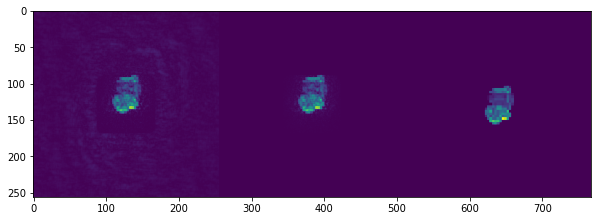

In [238]:
niteration = 1000
beta = 0.9
roi  = 128
n = 2*roi

t = numpy.linspace(-1,1,n)
xx,yy = numpy.meshgrid(t,t)
dx = t[1]-t[0]
s = 40
p = 10
support2d = 1.0*( ((xx)**p + (yy)**p) < (dx*s)**p )
#support2d = abs(recon_hio) > (2/100.0) * abs(recon_hio).max()

#measure = diffractogram2d[0,:,:]

_measure_ = numpy.fft.fftshift( measure )
_measure_[ _measure_ > 0 ] = numpy.sqrt( _measure_[ _measure_ > 0] )

initial = numpy.fft.fftshift( numpy.fft.ifft2( _measure_ * numpy.exp(1j * numpy.random.rand(measure.shape[0],measure.shape[1]) ) ).real )
#initial = support2d

recon_hio = hio_gpu( initial, _measure_, support2d, niteration, beta, "HIO" )
recon_er  = hio_gpu( recon_hio, _measure_, support2d, niteration, beta, "ER" )

#plt.figure(figsize=(10,10))
#plt.imshow( _measure_ )

plt.figure(figsize=(10,10))
plt.imshow( numpy.hstack((numpy.abs(recon_hio), numpy.abs(recon_er), tomogram[:,:,0]) ) )